In [1]:
import os, re
import pickle
import numpy as np
import pandas as pd

import joblib

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import matplotlib.colors as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable

#scipy
from scipy import ndimage
from scipy.stats import gaussian_kde

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import rioxarray
import xarray
import rasterio
import xarray as xr

## GDAL
from osgeo import gdal, osr, ogr

## WQ_SAT
from wq_sat import config
from wq_sat.satellites import sentinel2
from wq_sat.bathymetry import SDB
from wq_sat.utils import geo_utils, plot_utils, data_utils

In [ ]:
import os, re
import numpy as np
import pandas as pd

In [6]:
def get_bands(tiles, coordinates=None):
    
    tile_path = config.acolite_path(tiles[0])
    data_bands, coord = sentinel2.Rs_acolite(tile_path, coordinates)
    h, w = data_bands['B2'].shape

    ## Bands
    Rs492 = np.zeros((h, w, len(tiles)))
    Rs559 = np.zeros((h, w, len(tiles)))
    Rs665 = np.zeros((h, w, len(tiles)))
    Rs704 = np.zeros((h, w, len(tiles)))
    chl = np.zeros((h, w, len(tiles)))
    
    for t, tile in enumerate(tiles):

        tile_path = config.acolite_path(tile)
        data_bands, coord = sentinel2.Rs_acolite(tile_path, coordinates)

        ## Bands
        Rs492[:,:,t] = data_bands['B2']
        Rs559[:,:,t] = data_bands['B3']
        Rs665[:,:,t] = data_bands['B4']
        Rs704[:,:,t] = data_bands['B5']
        chl[:,:,t] = data_bands['chl']

    ## Bands quality proxies
    Rs492_c = np.nanmax(Rs492, axis=2) # Rs492 -> B2
    Rs559_c = np.nanmax(Rs559, axis=2) # Rs559 -> B3
    Rs665_c = np.nanmax(Rs665, axis=2) # Rs665 -> B4
    Rs704_c = np.nanmax(Rs704, axis=2) # Rs704 -> B5
    chl_c = np.nanmax(chl, axis=2) # chl
    
    return Rs492_c, Rs559_c, Rs665_c, Rs704_c, chl_c

def get_ratios(tiles, coordinates=None):
    
    tile_path = config.acolite_path(tiles[0])
    data_bands, coord = sentinel2.Rs_acolite(tile_path, coordinates)
    h, w = data_bands['B2'].shape

    ## Ratios
    Rt23 = np.zeros((h, w, len(tiles)))
    Rt24 = np.zeros((h, w, len(tiles)))
    Rt28 = np.zeros((h, w, len(tiles)))
    Rt34 = np.zeros((h, w, len(tiles)))
    Rt38 = np.zeros((h, w, len(tiles)))    
    Rt48 = np.zeros((h, w, len(tiles)))
    
    for t, tile in enumerate(tiles):

        tile_path = config.acolite_path(tile)
        data_bands, coord = sentinel2.Rs_acolite(tile_path, coordinates)

        ## Water quality proxies
        Rt23[:,:,t] = np.log(3140*data_bands['B2'])/np.log(3140*data_bands['B3'])
        Rt24[:,:,t] = np.log(3140*data_bands['B2'])/np.log(3140*data_bands['B4'])
        Rt28[:,:,t] = np.log(3140*data_bands['B2'])/np.log(3140*data_bands['B8'])
        Rt34[:,:,t] = np.log(3140*data_bands['B3'])/np.log(3140*data_bands['B4'])
        Rt38[:,:,t] = np.log(3140*data_bands['B3'])/np.log(3140*data_bands['B8'])
        Rt48[:,:,t] = np.log(3140*data_bands['B4'])/np.log(3140*data_bands['B8'])
        
    ## Bands quality proxies
    Rt23_c = np.nanmax(Rt23, axis=2)
    Rt24_c = np.nanmax(Rt24, axis=2)
    Rt28_c = np.nanmax(Rt28, axis=2)    
    Rt34_c = np.nanmax(Rt34, axis=2)
    Rt38_c = np.nanmax(Rt38, axis=2)
    Rt48_c = np.nanmax(Rt48, axis=2)
    
    return Rt23_c, Rt24_c, Rt28_c, Rt34_c, Rt38_c, Rt48_c

def get_Lyzenga(tiles, coordinates=None):
    
    tile_path = config.acolite_path(tiles[0])
    data_bands, coord = sentinel2.Rs_acolite(tile_path, coordinates)
    h, w = data_bands['B2'].shape

    ## Ratios
    Lt2 = np.zeros((h, w, len(tiles)))
    Lt3 = np.zeros((h, w, len(tiles)))
    Lt4 = np.zeros((h, w, len(tiles)))
    Lt8 = np.zeros((h, w, len(tiles)))
    
    for t, tile in enumerate(tiles):

        tile_path = config.acolite_path(tile)
        data_bands, coord = sentinel2.Rs_acolite(tile_path, coordinates)

        ## Water quality proxies
        Lt2[:,:,t] = np.log(data_bands['B2'] - np.nanmin(data_bands['B2']))
        Lt3[:,:,t] = np.log(data_bands['B3'] - np.nanmin(data_bands['B3']))
        Lt4[:,:,t] = np.log(data_bands['B4'] - np.nanmin(data_bands['B4']))
        Lt8[:,:,t] = np.log(data_bands['B8'] - np.nanmin(data_bands['B8']))
                                    
    ## Bands quality proxies
    Lt2_c = np.nanmax(Lt2, axis=2)
    Lt3_c = np.nanmax(Lt3, axis=2)
    Lt4_c = np.nanmax(Lt4, axis=2)
    Lt8_c = np.nanmax(Lt8, axis=2)
    
    return Lt2_c, Lt3_c, Lt4_c, Lt8_c

In [15]:
bathymetries = {'CalaMillor': ['2018', '2019', '2020'],
                'SanBou': ['2017', '2021', '2022'],
                'Muro': ['2023']
               }

2018 - 11350
2019 - 12073
2020 - 12454
2017 - 4667
2021 - 16309
2022 - 12802
2023 - 8318
-20.315059647932735 - -0.032379223307694646


Text(0.5, 1.0, 'Initu Bathymetry')

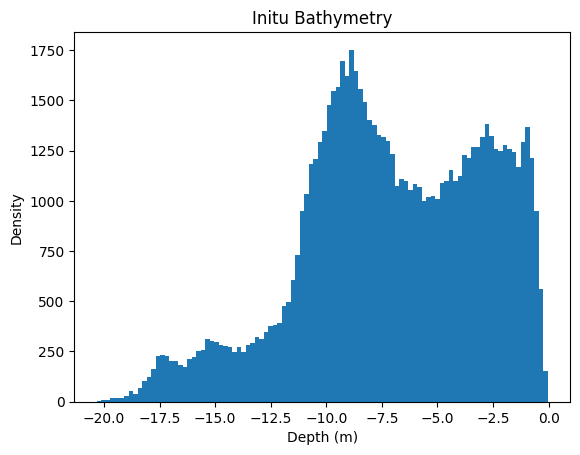

In [16]:
arr_bathymetry = []
for region in bathymetries.keys():
    for year in bathymetries[region]:
        path = os.path.join(config.data_path(), 'bathymetries', region, 'InSitu')
        file = '{}_Insitu_bathymetry_EPSG32631_{}.tif'.format(region, year)
        bathymetry, BBox, crs = geo_utils.load_geotiff(os.path.join(path, file))
        mx = np.ma.masked_invalid(bathymetry)
        print('{} - {}'.format(year, np.sum(~mx.mask)))
        arr_bathymetry.append(bathymetry.flatten())
        
arr_bathymetry = np.hstack(arr_bathymetry)
print('{} - {}'.format(np.nanmin(arr_bathymetry), np.nanmax(arr_bathymetry)))
plt.hist(arr_bathymetry, bins=100)  # arguments are passed to np.histogram
plt.xlabel('Depth (m)')
plt.ylabel('Density')
plt.title('Initu Bathymetry')

In [30]:
arr_bathymetry = []
Rt23 = []
Rt24 = []
Rt28 = []
Rt34 = []
Rt38 = []

Rt23_c, Rt24_c, Rt28_c, Rt34_c, Rt38_c, Rt48_c

for region in bathymetries.keys():
    for year in bathymetries[region]:
        
        path = os.path.join(config.data_path(), 'bathymetries', region, 'InSitu')
        file = '{}_Insitu_bathymetry_EPSG32631_{}.tif'.format(region, year)
        
        bathymetry, BBox, crs = geo_utils.load_geotiff(os.path.join(path, file))
        mx = np.ma.masked_invalid(bathymetry)
        arr_bathymetry.append(bathymetry.flatten())

        ## transform coordinates
        new_ul = geo_utils.transform_coordinates(BBox[0], inputEPSG=crs, outputEPSG=4326)
        new_lr = geo_utils.transform_coordinates(BBox[1], inputEPSG=crs, outputEPSG=4326)

        # ROI
        roi_coord = {'N': new_ul[0], 'W': new_ul[1], 'S': new_lr[0], 'E': new_lr[1]}
        
        tiles = config.get_tiles(rezgion, year)
        
        Rs492_c, Rs559_c, Rs665_c, Rs704_c, chl_c = get_bands(tiles, roi_coord)
        Rs492.append(Rs492_c.flatten())
        Rs559.append(Rs559_c.flatten())
        Rs665.append(Rs665_c.flatten())
        Rs704.append(Rs704_c.flatten())
        chl.append(chl_c.flatten())
        
arr_bathymetry = np.hstack(arr_bathymetry)
Rs492 = np.hstack(Rs492)
Rs559 = np.hstack(Rs559)
Rs665 = np.hstack(Rs665)
Rs704 = np.hstack(Rs704)
chl = np.hstack(chl)

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20181002T103021_N0206_R108_T31SED_20181002T142247
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20181002T103021_N0206_R108_T31SED_20181002T142247
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20181025T104121_N0206_R008_T31SED_20181025T125227
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20180917T103019_N0206_R108_T31SED_20180917T161011
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Image size: width=75 x height=191
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20180920T104019_N0206_R008_T31SED_20180920T143638
Selected pixel region: xmin=3301, ymin=1624, xmax=3375, ymax=1814:
Imag

/tmp/ipykernel_141770/2260393995.py:63: RuntimeWarning: All-NaN slice encountered
  Rt23_c = np.nanmax(Rt23, axis=2)
/tmp/ipykernel_141770/2260393995.py:64: RuntimeWarning: All-NaN slice encountered
  Rt24_c = np.nanmax(Rt24, axis=2)
/tmp/ipykernel_141770/2260393995.py:65: RuntimeWarning: All-NaN slice encountered
  Rt28_c = np.nanmax(Rt28, axis=2)
/tmp/ipykernel_141770/2260393995.py:66: RuntimeWarning: All-NaN slice encountered
  Rt34_c = np.nanmax(Rt34, axis=2)
/tmp/ipykernel_141770/2260393995.py:67: RuntimeWarning: All-NaN slice encountered
  Rt38_c = np.nanmax(Rt38, axis=2)
/tmp/ipykernel_141770/2260393995.py:68: RuntimeWarning: All-NaN slice encountered
  Rt48_c = np.nanmax(Rt48, axis=2)


Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20190920T104021_N0208_R008_T31SED_20190920T111121
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20190920T104021_N0208_R008_T31SED_20190920T111121
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20190930T104021_N0208_R008_T31SED_20190930T125317
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20191007T103021_N0208_R108_T31SED_20191007T124441
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Image size: width=77 x height=190
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20191027T103131_N0208_R108_T31SED_20191027T105507
Selected pixel region: xmin=3301, ymin=1619, xmax=3377, ymax=1808:
Imag

Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20220802T102611_N0400_R108_T31TEE_20220802T141116
Selected pixel region: xmin=8991, ymin=8197, xmax=9222, ymax=8364:
Image size: width=232 x height=168
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20220723T102611_N0400_R108_T31TEE_20220723T154923
Selected pixel region: xmin=8991, ymin=8197, xmax=9222, ymax=8364:
Image size: width=232 x height=168
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20220713T103041_N0400_R108_T31TEE_20220713T141110
Selected pixel region: xmin=8991, ymin=8197, xmax=9222, ymax=8364:
Image size: width=232 x height=168
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2A_MSIL1C_20220613T103031_N0400_R108_T31TEE_20220613T140948
Selected pixel region: xmin=8991, ymin=8197, xmax=9222, ymax=8364:
Image size: width=232 x height=168
Loading /home/wqsat_data/Sentinel-2/ACOLITE/S2B_MSIL1C_20230325T102649_N0509_R108_T31TEE_20230325T122948
Selected pixel region: xmin=1000, ymin=9257, xmax=1109, ymax=9350:


In [18]:
df_bands = pd.DataFrame({'bathymetry': -arr_bathymetry, 
                         'Rs492': Rs492,
                         'Rs559': Rs559,
                         'Rs665': Rs665,
                         'Rs704': Rs704,
                         'chl': chl,
                        })

df_bands.loc[df_bands.isnull().any(axis=1), :] = np.nan

# Correlations Matrix
corr = df_bands.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,bathymetry,Rs492,Rs559,Rs665,Rs704,chl
bathymetry,nan,nan,nan,nan,nan,nan
Rs492,-0.80,nan,nan,nan,nan,nan
Rs559,-0.83,0.98,nan,nan,nan,nan
Rs665,-0.52,0.71,0.77,nan,nan,nan
Rs704,-0.39,0.56,0.62,0.92,nan,nan
chl,-0.79,0.70,0.76,0.57,0.48,nan


In [28]:
depths = [1, 3, 5, 10, 15, 20]
df = df_bands[df_bands['bathymetry'] < 20]

# Correlations Matrix
corr = df.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,bathymetry,Rs492,Rs559,Rs665,Rs704,chl
bathymetry,nan,nan,nan,nan,nan,nan
Rs492,-0.80,nan,nan,nan,nan,nan
Rs559,-0.83,0.98,nan,nan,nan,nan
Rs665,-0.52,0.71,0.77,nan,nan,nan
Rs704,-0.39,0.56,0.62,0.92,nan,nan
chl,-0.79,0.70,0.76,0.57,0.48,nan


## Ratios

In [ ]:
arr_bathymetry = []
Rt23 = []
Rt24 = []
Rt28 = []
Rt34 = []
Rt38 = []
Rt48 = []

for region in bathymetries.keys():
    for year in bathymetries[region]:
        
        path = os.path.join(config.data_path(), 'bathymetries', region, 'InSitu')
        file = '{}_Insitu_bathymetry_EPSG32631_{}.tif'.format(region, year)
        
        bathymetry, BBox, crs = geo_utils.load_geotiff(os.path.join(path, file))
        mx = np.ma.masked_invalid(bathymetry)
        arr_bathymetry.append(bathymetry.flatten())

        ## transform coordinates
        new_ul = geo_utils.transform_coordinates(BBox[0], inputEPSG=crs, outputEPSG=4326)
        new_lr = geo_utils.transform_coordinates(BBox[1], inputEPSG=crs, outputEPSG=4326)

        # ROI
        roi_coord = {'N': new_ul[0], 'W': new_ul[1], 'S': new_lr[0], 'E': new_lr[1]}
        
        tiles = config.get_tiles(region, year)
        
        Rt23_c, Rt24_c, Rt28_c, Rt34_c, Rt38_c, Rt48_c = get_ratios(tiles, roi_coord)
        
        Rt23.append(Rt23_c.flatten())
        Rt24.append(Rt24_c.flatten())
        Rt28.append(Rt28_c.flatten())
        Rt34.append(Rt34_c.flatten())
        Rt38.append(Rt38_c.flatten())
        Rt48.append(Rt48_c.flatten())
        
arr_bathymetry = np.hstack(arr_bathymetry)
Rt23 = np.hstack(Rt23)
Rt24 = np.hstack(Rt24)
Rt28 = np.hstack(Rt28)
Rt34 = np.hstack(Rt34)
Rt38 = np.hstack(Rt38)
Rt48 = np.hstack(Rt48)

In [31]:
df_ratios = pd.DataFrame({'bathymetry': -arr_bathymetry, 
                          'Rt23': Rt23,
                          'Rt24': Rt24,
                          'Rt28': Rt28,
                          'Rt34': Rt34,
                          'Rt38': Rt38,
                          'Rt48': Rt48,
                        })

df_ratios.loc[df_ratios.isnull().any(axis=1), :] = np.nan

# Correlations Matrix
corr = df_ratios.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,bathymetry,Rt23,Rt24,Rt28,Rt34,Rt38,Rt48
bathymetry,nan,nan,nan,nan,nan,nan,nan
Rt23,0.88,nan,nan,nan,nan,nan,nan
Rt24,0.01,0.01,nan,nan,nan,nan,nan
Rt28,0.00,0.00,0.00,nan,nan,nan,nan
Rt34,0.01,0.01,1.00,-0.00,nan,nan,nan
Rt38,-0.00,-0.00,0.00,1.00,-0.00,nan,nan
Rt48,-0.01,-0.01,-0.00,0.97,-0.00,0.98,nan


In [37]:
depths = [1, 3, 5, 10, 15, 20]
df = df_ratios[df_ratios['bathymetry'] < 20]

# Correlations Matrix
corr = df.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,bathymetry,Rt23,Rt24,Rt28,Rt34,Rt38,Rt48
bathymetry,nan,nan,nan,nan,nan,nan,nan
Rt23,0.89,nan,nan,nan,nan,nan,nan
Rt24,0.01,0.01,nan,nan,nan,nan,nan
Rt28,0.00,-0.00,0.00,nan,nan,nan,nan
Rt34,0.01,0.01,1.00,-0.00,nan,nan,nan
Rt38,-0.00,-0.00,0.00,1.00,-0.00,nan,nan
Rt48,-0.01,-0.01,-0.00,0.97,-0.00,0.98,nan
